In [ ]:
# !pip install semilearn==0.3.1
# !pip install semilearn
# !nvidia-smi

In [ ]:
!pip install segmentation_models_pytorch

In [ ]:
!pip install torchmetrics

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset, random_split
import numpy as np
import albumentations as A
from albumentations.pytorch import ToTensorV2
from tqdm import tqdm
import random
from accelerate import Accelerator
import torchmetrics
import segmentation_models_pytorch as smp
import os
import cv2
accelerator = Accelerator(mixed_precision='fp16')

In [ ]:
# import semilearn
# # from semilearn import get_dataset, get_data_loader, get_net_builder, get_algorithm, get_config, Trainer
# import numpy as np
# from torchvision import transforms
# from semilearn import split_ssl_data, BasicDataset
# import os

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Get filepaths for input data

In [ ]:
training_folder = '/content/drive/MyDrive/HOTOSM-Earth_Observation/Data/Copy of Omdena AI challenge datasets 02-2024'

In [ ]:
# prompt: get this table from this url: https://github.com/hotosm/fAIr-utilities/blob/master/docs/benchmark/training_datasets.csv , make it into a dataframe, then merge with the folder names in https://drive.google.com/drive/folders/1jK4ua8xNxsEB4ArK6GbmsnPoEj3KBrJU?usp=drive_link so that for each folder I have access to, I have the additional information from the training_datasets.csv

import pandas as pd
from google.colab import drive
import os

# Load the CSV file from GitHub
try:
    df_training_datasets = pd.read_csv('https://raw.githubusercontent.com/hotosm/fAIr-utilities/master/docs/benchmark/training_datasets.csv')
except Exception as e:
    print(f"Error loading CSV from GitHub: {e}")
    df_training_datasets = pd.DataFrame()  # Create an empty DataFrame in case of error

# Define the path to the Google Drive folder
folder_path = training_folder # Replace with your actual folder path

try:
    # Get the list of folder names
    folder_names = [f for f in os.listdir(training_folder) if os.path.isdir(os.path.join(training_folder, f))]
    # Create a DataFrame with the folder names

    df_folders = pd.DataFrame({'folder_name': folder_names})
    df_folders['id_train'] = df_folders['folder_name'].apply(lambda x: x.split('_')[1])
    df_folders['id_train'] = df_folders['id_train'].astype(int)

    # Merge the two DataFrames
    merged_df = pd.merge(df_folders, df_training_datasets, how='left', left_on='id_train', right_on='id_train')
    # print(merged_df)

except Exception as e:
    print(f"Error processing folder data or merging DataFrames: {e}")
    merged_df = pd.DataFrame() # Create an empty DataFrame in case of error

merged_df = merged_df.sort_values(by=['id_train'])


In [ ]:
merged_df

folder_name  id_train   id  id_model  ds_size  urban_region      country  \
4  training_364       364  1.0      51.0    399.0        Kakuma        Kenya   
8  training_385       385  NaN       NaN      NaN           NaN          NaN   
0  training_386       386  NaN       NaN      NaN           NaN          NaN   
1  training_389       389  NaN       NaN      NaN           NaN          NaN   
7  training_397       397  7.0     112.0    756.0     Melbourne    Australia   
6  training_398       398  8.0     113.0    152.0         Pemba     Tanzania   
5  training_399       399  9.0     114.0    294.0  Christchurch  New Zealand   
3  training_403       403  NaN       NaN      NaN           NaN          NaN   
2  training_404       404  NaN       NaN      NaN           NaN          NaN   

  continent  id_dataset    urban_type density roof_type Unnamed: 11  
4    Africa        58.0  refugee camp  sparse     metal         NaN  
8       NaN         NaN           NaN     NaN       NaN         NaN  
0       NaN         NaN           NaN     NaN       NaN         NaN  
1       NaN         NaN           NaN     NaN       NaN         NaN  
7   Oceania       171.0         urban    grid    cement         NaN  
6    Africa       170.0         rural  sparse     metal         NaN  
5   Oceania       177.0    peri-urban  sparse  shingles         NaN  
3       NaN         NaN           NaN     NaN       NaN         NaN  
2       NaN         NaN           NaN     NaN       NaN         NaN

In [ ]:
#get image paths of training data
def get_image_paths(root_dir,paths_needed:str = 'chips'):
    """
    Walks through a directory and its subdirectories to find image files.

    Args:
        root_dir: The root directory to start the search.
        paths_needed: The type of image files to search for. ('chips','bin_mask','multi_mask')


    Returns:
        A list of strings, where each string is a full path to an image file.
        Returns an empty list if no image files are found or if the root directory is invalid.
    """
    image_extensions = ('.jpg', '.jpeg', '.png', '.bmp', '.tiff','.tif','.geojson')  # Add more if needed
    image_paths = []

    if not os.path.isdir(root_dir):
        print(f"Error: '{root_dir}' is not a valid directory.")
        return []

    if paths_needed == 'chips':
        folder_to_find = 'chips'
    elif paths_needed == 'bin_mask':
        folder_to_find = 'binarymasks'
    elif paths_needed == 'multi_mask':
        folder_to_find = 'labels'

    for root, dirs, files in os.walk(root_dir,topdown=True):
        for dirname in dirs:
          # print(dirname)
          if dirname.lower() == folder_to_find:
              for filename in os.listdir(os.path.join(root, dirname)):
                  if filename.lower().endswith(image_extensions):
                      image_paths.append(os.path.join(root, dirname, filename))
    return image_paths

folder_paths = {}
for folder in os.listdir(training_folder):
  if os.path.isdir(os.path.join(training_folder,folder)):
    temp_chips = get_image_paths(os.path.join(training_folder,folder),'chips')
    temp_bin_masks = get_image_paths(os.path.join(training_folder,folder),'bin_mask')
    temp_multi_masks = get_image_paths(os.path.join(training_folder,folder),'multi_mask')
    folder_paths[folder]={'chips':temp_chips,'bin_mask':temp_bin_masks,'multi_mask':temp_multi_masks}

print(folder_paths.keys())
#

dict_keys(['training_386', 'training_389', 'training_404', 'training_403', 'training_364', 'training_399', 'training_398', 'training_397', 'training_385'])


In [ ]:
folder_paths_sorted = {k:folder_paths[k] for k in sorted(folder_paths.keys())}
print(folder_paths_sorted.keys())

dict_keys(['training_364', 'training_385', 'training_386', 'training_389', 'training_397', 'training_398', 'training_399', 'training_403', 'training_404'])


In [ ]:
#find size of datasets
train_set_sizes = []
for train_set in folder_paths_sorted.keys():
  print(train_set)
  total_chips = len(folder_paths_sorted[train_set]['chips'])
  print(total_chips)
  train_set_sizes.append(total_chips)


training_364
399
training_385
546
training_386
168
training_389
399
training_397
756
training_398
184
training_399
294
training_403
168
training_404
420


In [ ]:
#add missing dataset sizes into table
merged_df['ds_size'] = train_set_sizes
merged_df

folder_name  id_train   id  id_model  ds_size  urban_region      country  \
4  training_364       364  1.0      51.0      399        Kakuma        Kenya   
8  training_385       385  NaN       NaN      546           NaN          NaN   
0  training_386       386  NaN       NaN      168           NaN          NaN   
1  training_389       389  NaN       NaN      399           NaN          NaN   
7  training_397       397  7.0     112.0      756     Melbourne    Australia   
6  training_398       398  8.0     113.0      184         Pemba     Tanzania   
5  training_399       399  9.0     114.0      294  Christchurch  New Zealand   
3  training_403       403  NaN       NaN      168           NaN          NaN   
2  training_404       404  NaN       NaN      420           NaN          NaN   

  continent  id_dataset    urban_type density roof_type Unnamed: 11  
4    Africa        58.0  refugee camp  sparse     metal         NaN  
8       NaN         NaN           NaN     NaN       NaN         NaN  
0       NaN         NaN           NaN     NaN       NaN         NaN  
1       NaN         NaN           NaN     NaN       NaN         NaN  
7   Oceania       171.0         urban    grid    cement         NaN  
6    Africa       170.0         rural  sparse     metal         NaN  
5   Oceania       177.0    peri-urban  sparse  shingles         NaN  
3       NaN         NaN           NaN     NaN       NaN         NaN  
2       NaN         NaN           NaN     NaN       NaN         NaN

In [ ]:
#make filepaths for specific dataset
mel_aus_chips = folder_paths_sorted['training_397']['chips']
mel_aus_masks = folder_paths_sorted['training_397']['bin_mask']
def make_matching_filepaths(img_paths,mask_paths):

  img_paths_out = []
  mask_paths_out = []
  for img_path in img_paths:
    for mask_path in mask_paths:
      if img_path.split('/')[-1].split('.')[0] == mask_path.split('/')[-1].split('.')[0]:
        img_paths_out.append(img_path)
        mask_paths_out.append(mask_path)
        break
  return img_paths_out, mask_paths_out

img_paths_matching, mask_paths_matching = make_matching_filepaths(mel_aus_chips,mel_aus_masks)

print(len(img_paths_matching))
print(len(mask_paths_matching))
for x in range(5):
  print(img_paths_matching[x])
  print(mask_paths_matching[x])

756
756
/content/drive/MyDrive/HOTOSM-Earth_Observation/Data/Copy of Omdena AI challenge datasets 02-2024/training_397/preprocessed/chips/OAM-1892826-1286711-21.tif
/content/drive/MyDrive/HOTOSM-Earth_Observation/Data/Copy of Omdena AI challenge datasets 02-2024/training_397/preprocessed/binarymasks/OAM-1892826-1286711-21.mask.tif
/content/drive/MyDrive/HOTOSM-Earth_Observation/Data/Copy of Omdena AI challenge datasets 02-2024/training_397/preprocessed/chips/OAM-1892832-1286715-21.tif
/content/drive/MyDrive/HOTOSM-Earth_Observation/Data/Copy of Omdena AI challenge datasets 02-2024/training_397/preprocessed/binarymasks/OAM-1892832-1286715-21.mask.tif
/content/drive/MyDrive/HOTOSM-Earth_Observation/Data/Copy of Omdena AI challenge datasets 02-2024/training_397/preprocessed/chips/OAM-473239-321686-19.tif
/content/drive/MyDrive/HOTOSM-Earth_Observation/Data/Copy of Omdena AI challenge datasets 02-2024/training_397/preprocessed/binarymasks/OAM-473239-321686-19.mask.tif
/content/drive/MyDriv

In [ ]:
# Define validation split ratio
val_ratio = 0.1  # 10% for validation

# Ensure we have enough validation examples
num_val_examples = min(int(len(img_paths_matching) * val_ratio), len(img_paths_matching) - 1)

# Get random validation indices
val_idx = np.random.choice(len(img_paths_matching), num_val_examples, replace=False)

# Split into training and validation
img_paths_valid = [img_paths_matching[i] for i in val_idx]
mask_paths_valid = [mask_paths_matching[i] for i in val_idx]

img_paths_train = [img_paths_matching[i] for i in range(len(img_paths_matching)) if i not in val_idx]
mask_paths_train = [mask_paths_matching[i] for i in range(len(mask_paths_matching)) if i not in val_idx]

# Ensure we have at least 1 training image
if len(img_paths_train) == 0:
    raise ValueError("Not enough images left for training. Reduce val_ratio.")

# Print counts
print(f"Training images: {len(img_paths_train)}")
print(f"Training masks: {len(mask_paths_train)}")
print(f"Validation images: {len(img_paths_valid)}")
print(f"Validation masks: {len(mask_paths_valid)}")


Training images: 681
Training masks: 681
Validation images: 75
Validation masks: 75


In [ ]:
unlabelled_ratio = 0.5
num_unlabellled = int(len(img_paths_train)*unlabelled_ratio)
unlabelled_idx = np.random.choice(len(img_paths_train), num_unlabellled, replace=False)
img_paths_unlabelled = [img_paths_train[i] for i in unlabelled_idx]
img_paths_train_labelled = [img_paths_train[i] for i in range(len(img_paths_train)) if i not in unlabelled_idx]
mask_paths_train_labelled = [mask_paths_train[i] for i in range(len(mask_paths_train)) if i not in unlabelled_idx]


### Make datasets and dataloaders

In [ ]:
class LabeledSegmentationDataset(Dataset):
    """Handles labeled data for supervised segmentation training."""

    def __init__(self, image_paths, mask_paths, transform=None,upsample_ratio=1):
        """
        Args:
            image_paths (list): List of image file paths.
            mask_paths (list): List of corresponding mask file paths.
            transform (callable, optional): Optional transform to be applied.
        """
        assert len(image_paths) == len(mask_paths), "Mismatch between images and masks"

        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.transform = transform
        self.upsample_ratio = upsample_ratio

        if self.upsample_ratio > 1:
          self.image_paths = self.image_paths*self.upsample_ratio
          self.mask_paths = self.mask_paths*self.upsample_ratio

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        # Load image
        image = cv2.imread(self.image_paths[idx], cv2.IMREAD_UNCHANGED)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Ensure RGB format

        # Load mask
        mask = cv2.imread(self.mask_paths[idx], cv2.IMREAD_GRAYSCALE)  # Grayscale mask

        # Apply transforms
        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image, mask = augmented['image'], augmented['mask']

        # if not isinstance(image, np.ndarray):
        #   image = image.numpy()

        # # Convert to PyTorch tensor (H, W, C) → (C, H, W)
        # image = torch.from_numpy(image).float().permute(1, 2, 0)  # (H, W, C) → (C, H, W)


        return image, mask


In [ ]:
class UnlabeledSegmentationDataset(Dataset):
    """Handles unlabeled data for semi-supervised segmentation training, precomputing strong augmentations."""

    def __init__(self, image_paths, weak_transform=None, strong_transform=None,upsample_ratio=1):
        """
        Args:
            image_paths (list): List of image file paths.
            weak_transform (callable, optional): Weak transformation to be applied to generate pseudo-labels.
            strong_transform (callable, optional): Strong transformation for consistency training.
        """
        self.image_paths = image_paths
        self.weak_transform = weak_transform
        self.strong_transform = strong_transform
        self.upsample_ratio = upsample_ratio

        if self.upsample_ratio > 1:
          self.image_paths = self.image_paths*self.upsample_ratio

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        # Load image
        image = cv2.imread(self.image_paths[idx], cv2.IMREAD_UNCHANGED)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Ensure RGB format

        # Apply weak transformation (used for pseudo-labels)
        if self.weak_transform is not None:
            weak_aug = self.weak_transform(image=image)
            weak_image = weak_aug["image"]
        else:
            weak_image = image

        # Apply strong transformation (used for consistency regularization)
        if self.strong_transform is not None:
            strong_aug = self.strong_transform(image=image)
            strong_image = strong_aug["image"]
        else:
            strong_image = image

        # Convert to PyTorch tensor (C, H, W)
        # weak_image = torch.from_numpy(weak_image).float().permute(2, 0, 1)  # (H, W, C) → (C, H, W)
        # strong_image = torch.from_numpy(strong_image).float().permute(2, 0, 1)  # (H, W, C) → (C, H, W)

        return weak_image, strong_image  # Return both versions of the image so augments not made in training step


In [ ]:
#define transforms
train_transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    A.GaussNoise(p=0.2),
    A.Normalize(mean=(0.5,), std=(0.5,)),
    ToTensorV2()
])

val_transform = A.Compose([
    A.Normalize(mean=(0.5,), std=(0.5,)),
    ToTensorV2()
])

weak_augment = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.Normalize(mean=(0.5,), std=(0.5,)),
    ToTensorV2()
])

strong_augment = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.GaussNoise(p=0.3),
    A.ElasticTransform(alpha=1, sigma=50, alpha_affine=50, p=0.2),
    A.Normalize(mean=(0.5,), std=(0.5,)),
    ToTensorV2()
])

<ipython-input-72-335f23d79a6d>:26: UserWarning: Argument(s) 'alpha_affine' are not valid for transform ElasticTransform
  A.ElasticTransform(alpha=1, sigma=50, alpha_affine=50, p=0.2),


In [ ]:
train_transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.75),  # 90-degree rotations improve orientation generalization
    # A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.2, rotate_limit=30, p=0.5),  # Better handling of varying building angles & sizes
    A.RandomBrightnessContrast(p=0.3),
    A.RandomGamma(p=0.2),  # Simulates different exposure levels in satellite imagery
    A.GaussianBlur(p=0.2),  # Mimics resolution differences in images
    A.GaussNoise(p=0.3),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),  # Use ImageNet mean/std
    ToTensorV2()
])

val_transform_training = A.Compose([
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])

weak_augment = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])

strong_augment = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.GaussNoise(std_range=(0.2, 0.44), p=0.4),  # Increase noise variance
    A.ElasticTransform(alpha=10, sigma=50, p=0.3),  # Increase alpha for better deformation
    A.GridDistortion(num_steps=5, distort_limit=0.3, p=0.2),  # Simulates misalignment errors in images
    A.RandomBrightnessContrast(p=0.3),
    A.RandomResizedCrop(size=(256,256), scale=(0.8, 1.0), p=0.3),  # Cropping helps model generalize to different building scales
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])



In [ ]:
#make batches
BATCH_SIZE = 32

# Training Data
labelled_dataset = LabeledSegmentationDataset(img_paths_train_labelled,
                                              mask_paths_train_labelled,
                                              transform=train_transform,
                                              upsample_ratio = 3
                                              )
unlabelled_dataset = UnlabeledSegmentationDataset(img_paths_unlabelled,
                                                  weak_transform=weak_augment,
                                                  strong_transform=strong_augment,
                                                  upsample_ratio=5)
print(len(labelled_dataset))
print(len(unlabelled_dataset))

# Validation Data (Only labeled)
val_dataset = LabeledSegmentationDataset(img_paths_valid, mask_paths_valid, transform=val_transform)

# Create DataLoaders
labelled_loader = DataLoader(labelled_dataset,
                             batch_size=BATCH_SIZE,
                             shuffle=True,
                             num_workers=4,
                             pin_memory=True,
                             prefetch_factor=2,
                             persistent_workers=False)

unlabelled_loader = DataLoader(unlabelled_dataset, batch_size=BATCH_SIZE,
                             shuffle=True,
                             num_workers=4,
                             pin_memory=True,
                             prefetch_factor=2,
                             persistent_workers=False)

val_loader = DataLoader(val_dataset,
                        batch_size=BATCH_SIZE,
                        shuffle=False,
                        num_workers=2,
                        pin_memory=True)

# Check dataset shapes
for images, masks in labelled_loader:
    print(f"Labeled Batch - Image Shape: {images.shape}, Mask Shape: {masks.shape}")
    break

for images in unlabelled_loader:
    print(f"Unlabeled weak Batch - Image Shape: {images[0].shape}")
    print(f"Unlabeled strong Batch - Image Shape: {images[1].shape}")
    break

for images, masks in val_loader:
    print(f"Validation Batch - Image Shape: {images.shape}, Mask Shape: {masks.shape}")
    break


1023
1700
Labeled Batch - Image Shape: torch.Size([32, 3, 256, 256]), Mask Shape: torch.Size([32, 256, 256])
Unlabeled weak Batch - Image Shape: torch.Size([32, 3, 256, 256])
Unlabeled strong Batch - Image Shape: torch.Size([32, 3, 256, 256])
Validation Batch - Image Shape: torch.Size([32, 3, 256, 256]), Mask Shape: torch.Size([32, 256, 256])


### Define loss function

Make custom loss combining dice score and crossentropy

In [ ]:
def dice_loss(pred, target, smooth=1e-6):
    """
    Compute Dice Loss for multi-class segmentation.

    Args:
        pred (torch.Tensor): Model predictions (B, C, H, W) (logits before softmax).
        target (torch.Tensor): Ground truth labels (B, H, W) or (B, C, H, W) (one-hot encoded).
        smooth (float): Smoothing factor to prevent division by zero.

    Returns:
        torch.Tensor: Dice loss value.
    """
    # Ensure predictions go through softmax for multi-class tasks
    pred = F.softmax(pred, dim=1)  # Use softmax for multi-class

    # If target is not one-hot encoded, convert it
    if target.ndim == 3:  # Shape (B, H, W) -> Convert to (B, C, H, W)
        target = F.one_hot(target.long(), num_classes=pred.shape[1])  # Convert to (B, H, W, C)
        target = target.permute(0, 3, 1, 2).float()  # Rearrange to (B, C, H, W)

    # Compute Dice coefficient
    intersection = (pred * target).sum(dim=(2, 3))
    union = pred.sum(dim=(2, 3)) + target.sum(dim=(2, 3))

    # Compute Dice Loss
    dice_loss = 1 - (2. * intersection + smooth) / (union + smooth)
    return dice_loss.mean()  # Return mean loss across batch


class CombinedLoss(nn.Module):
    """CrossEntropy + Dice Loss"""
    def __init__(self):
        super().__init__()
        self.ce = nn.CrossEntropyLoss()

    def forward(self, pred, target):
        ce_loss = self.ce(pred, target.long())
        dice = dice_loss(pred, target)
        return ce_loss + dice.mean()

### Define training and validation steps

In [ ]:
def train_semi_supervised_step(model, labeled_loader, unlabeled_loader, optimizer, criterion, alpha=1.0):
    """
    Train a semi-supervised segmentation model using separate labeled and unlabeled dataloaders.
    Handles the case where there are more unlabeled batches than labeled batches.

    Args:
        model (torch.nn.Module): The segmentation model.
        labeled_loader (torch.utils.data.DataLoader): Dataloader containing labeled data.
        unlabeled_loader (torch.utils.data.DataLoader): Dataloader containing unlabeled data.
        optimizer (torch.optim.Optimizer): Optimizer for model training.
        criterion (torch.nn.Module): Loss function for supervised learning.
        alpha (float): Weighting factor for unsupervised loss (default: 1.0).

    Returns:
        tuple: (Average total loss, Average supervised loss, Average unsupervised loss) per epoch.
    """
    # Prepare for mixed precision & distributed training
    model, labeled_loader, unlabeled_loader, optimizer = accelerator.prepare(
        model, labeled_loader, unlabeled_loader, optimizer
    )

    model.train()
    total_loss_epoch = 0.0
    supervised_loss_epoch = 0.0
    unsupervised_loss_epoch = 0.0

    labeled_iter = iter(labeled_loader)
    unlabeled_iter = iter(unlabeled_loader)

    num_batches = max(len(labeled_loader), len(unlabeled_loader))

    for _ in tqdm(range(num_batches)):
        # Handle labeled batch (reset iterator if exhausted)
        try:
            labeled_images, labeled_masks = next(labeled_iter)
        except StopIteration:
            labeled_iter = iter(labeled_loader)  # Restart labeled dataset iterator
            labeled_images, labeled_masks = next(labeled_iter)

        labeled_images, labeled_masks = labeled_images.to(accelerator.device), labeled_masks.to(accelerator.device)

        # Compute supervised loss
        with accelerator.autocast():
            preds_labeled = model(labeled_images)
            loss_supervised = criterion(preds_labeled, labeled_masks)

        # Handle unlabeled batch (reset iterator if exhausted)
        try:
            unlabeled_images_no_aug, unlabeled_images_strong_aug = next(unlabeled_iter)
        except StopIteration:
            unlabeled_iter = iter(unlabeled_loader)  # Restart unlabeled dataset iterator
            unlabeled_images_no_aug, unlabeled_images_strong_aug = next(unlabeled_iter)

        unlabeled_images_no_aug = unlabeled_images_no_aug.to(accelerator.device)
        unlabeled_images_strong_aug = unlabeled_images_strong_aug.to(accelerator.device)

        # Compute unsupervised loss using pseudo-labels
        loss_unsupervised = torch.tensor(0.0, device=accelerator.device)
        if unlabeled_images_no_aug.shape[0] > 0:  # Check for unlabeled samples
            with torch.no_grad():
                weak_preds = model(unlabeled_images_no_aug)
                pseudo_labels = torch.argmax(torch.softmax(weak_preds, dim=1), dim=1)  # Convert logits to pseudo-labels

            # Compute strong predictions
                preds_strong = model(unlabeled_images_strong_aug)

                loss_unsupervised = F.cross_entropy(preds_strong, pseudo_labels)

        # Total loss (supervised + unsupervised)
        total_loss = loss_supervised + alpha * loss_unsupervised

        # Backpropagation with `accelerator`
        optimizer.zero_grad()
        accelerator.backward(total_loss)  # Handles mixed precision scaling automatically
        optimizer.step()

        # Accumulate loss for logging
        total_loss_epoch += total_loss.item()
        supervised_loss_epoch += loss_supervised.item()
        unsupervised_loss_epoch += loss_unsupervised.item()

    # Compute per-batch average loss
    avg_total_loss = round(total_loss_epoch / num_batches, 4)
    avg_supervised_loss = round(supervised_loss_epoch / num_batches, 4)
    avg_unsupervised_loss = round(unsupervised_loss_epoch / num_batches, 4)

    return avg_total_loss, avg_supervised_loss, avg_unsupervised_loss


In [ ]:
# iou_metric = torchmetrics.JaccardIndex(task="binary").to(accelerator.device)  # Use binary for segmentation
from torchmetrics.segmentation.mean_iou import MeanIoU
from torchmetrics.segmentation.dice import DiceScore
from torchmetrics.classification.accuracy import Accuracy

iou_metric = MeanIoU(num_classes=2, include_background=False).to(accelerator.device)
dice_metric = DiceScore(num_classes=2, include_background=False).to(accelerator.device)
acc_metric = Accuracy(task="binary").to(accelerator.device)

@torch.no_grad()
def validate(model, val_loader, criterion):
    """
    Perform validation on the model.

    Args:
        model (torch.nn.Module): The segmentation model.
        val_loader (torch.utils.data.DataLoader): Validation data loader.
        criterion (torch.nn.Module): Loss function.

    Returns:
        dict: Average validation loss, IoU score, Dice score, and Accuracy.
    """
    model.eval()
    total_loss = 0
    total_iou = 0
    total_dice = 0
    total_acc = 0
    num_samples = 0

    for batch in val_loader:
        images, masks = batch

        # Ensure images are in correct format (B, C, H, W) before moving to device
        if images.shape[-1] == 3:  # Only permute if last dim is channels
            images = images.permute(0, 3, 1, 2)

        # Move data to the correct device using `accelerate`
        images, masks = images.to(accelerator.device), masks.to(accelerator.device)

        with accelerator.autocast():  # Enable mixed precision
            images = images.to(dtype=torch.float16)  # Match model dtype
            masks = masks.long()  # Ensure masks are integer class labels

            preds = model(images)  # Forward pass

            # Compute loss
            loss = criterion(preds, masks)
            total_loss += loss.item() * images.shape[0]  # Scale loss by batch size

            # Convert logits to class labels
            preds_classes = torch.argmax(preds, dim=1)

            # Compute IoU
            iou = iou_metric(preds_classes, masks)
            total_iou += iou.item() * images.shape[0]  # Scale IoU by batch size

            # Compute Dice Score
            dice = dice_metric(preds_classes.float(), masks.float())
            total_dice += dice.item() * images.shape[0]  # Scale Dice by batch size

            # Compute Pixel Accuracy
            acc = acc_metric(preds_classes, masks)
            total_acc += acc.item() * images.shape[0]  # Scale Accuracy by batch size

            num_samples += images.shape[0]

    # Normalize by total number of samples
    loss_out = round(total_loss / num_samples, 4)
    iou_out = round(total_iou / num_samples, 4)
    dice_out = round(total_dice / num_samples, 4)
    acc_out = round(total_acc / num_samples, 4)

    out_dict = {'val_loss':loss_out, 'val_iou':iou_out, 'val_dice':dice_out, 'val_acc':acc_out}
    out_dict = {k: round(v, 4) for k, v in out_dict.items()}
    return out_dict


In [ ]:
#https://github.com/qubvel-org/segmentation_models.pytorch/blob/main/docs/encoders.rst
NUM_CLASSES = 2

# Available models: Unet, UnetPlusPlus, MAnet, Linknet, FPN, PSPNet, DeepLabV3, DeepLabV3Plus, PAN
# MODEL_NAME = 'Unet'
MODEL_NAME = 'DeepLabV3Plus'
# Available encoders: see the smp documentation for a full list
# ENCODER_NAME = 'resnet34'
ENCODER_NAME = 'mit_b3'
ENCODER_WEIGHTS = 'imagenet' # Use pre-trained weights on ImageNet


model = smp.create_model(
    arch=MODEL_NAME,
    encoder_name=ENCODER_NAME,
    encoder_weights=ENCODER_WEIGHTS,
    in_channels=3, # Change if your images have a different number of channels
    classes=NUM_CLASSES
    )


In [ ]:
import inspect
print(str(model.__class__))


<class 'segmentation_models_pytorch.decoders.deeplabv3.model.DeepLabV3Plus'>


### Training

In [ ]:
#early stopping
import os
import torch
import numpy as np

class EarlyStopping:
    """Stops training if validation loss doesn't improve after a given patience period and saves the best model."""

    def __init__(self, patience=5, verbose=False, delta=0, save_path='.', trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved. Default: 5
            verbose (bool): If True, prints a message for each validation loss improvement. Default: False
            delta (float): Minimum change in monitored loss to be considered improvement. Default: 0
            save_path (str): Directory where the best checkpoint is saved. Default: '.'
            trace_func (function): Function for logging (default: print)
        """
        self.patience = patience
        self.verbose = verbose
        self.delta = delta
        self.save_path = save_path
        self.trace_func = trace_func

        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.counter = 0

        # Ensure save directory exists
        if not os.path.exists(self.save_path):
          os.makedirs(self.save_path, exist_ok=True)

    def __call__(self, val_loss, model):
        """
        Checks if the validation loss improved, saves the best model, and triggers early stopping if needed.
        """
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0  # Reset patience counter when improvement occurs

    def save_checkpoint(self, val_loss, model):
        """Saves the model state when validation loss improves, overwriting the previous best checkpoint."""
        checkpoint_path = os.path.join(self.save_path, 'best_checkpoint.pt')
        torch.save(model.state_dict(), checkpoint_path)
        self.val_loss_min = val_loss

        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}). Saving model to {checkpoint_path}')


In [ ]:
import torch

def save_checkpoint(model_name,optimizer, epoch, loss, save_path="model_checkpoint.pth"):
    """
    Saves the entire model, optimizer state, epoch, and loss for later reconstruction.

    Args:
        model (torch.nn.Module): The model to save.
        optimizer (torch.optim.Optimizer): The optimizer used in training.
        epoch (int): The current epoch number.
        loss (float): The loss value at this checkpoint.
        save_path (str): Path to save the checkpoint file.
    """
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss,
        'model_class': model.__class__.__name__  # Store model class name
    }
    torch.save(checkpoint, save_path)
    print(f"Checkpoint saved at {save_path}")

def load_checkpoint(model_class, optimizer_class, checkpoint_path="model_checkpoint.pth"):
    """
    Loads the entire model, optimizer state, epoch, and loss from a checkpoint.

    Args:
        model_class (torch.nn.Module): The model class to instantiate.
        optimizer_class (torch.optim.Optimizer): The optimizer class to instantiate.
        checkpoint_path (str): Path to the saved checkpoint file.

    Returns:
        model (torch.nn.Module): Loaded model with weights.
        optimizer (torch.optim.Optimizer): Loaded optimizer state.
        epoch (int): The epoch at which the checkpoint was saved.
        loss (float): The loss at which the checkpoint was saved.
    """
    checkpoint = torch.load(checkpoint_path)

    # Reconstruct model & optimizer
    model = model_class()
    optimizer = optimizer_class(model.parameters())

    # Load states
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']
    loss = checkpoint['loss']

    print(f"Checkpoint loaded from {checkpoint_path} (Epoch {epoch}, Loss: {loss})")
    return model, optimizer, epoch, loss

# Example Usage
# model = UNet()  # Replace with your model
# optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
# save_checkpoint(model, optimizer, epoch=10, loss=0.45)

# Load model later
# model, optimizer, start_epoch, last_loss = load_checkpoint(UNet, torch.optim.Adam)


In [ ]:
# from pytorch_lightning.callbacks import ModelCheckpoint

# checkpoint_callback = ModelCheckpoint(
#     dirpath='checkpoints/',
#     filename='epoch={epoch:02d}-val_loss={val_loss:.2f}',
#     monitor='val_loss',
#     save_top_k=-1,  # Save all checkpoints
#     every_n_epochs=5  # Save checkpoint every n epochs
# )


In [ ]:
def find_most_recent_checkpoint(checkpoint_folder):
    """
    Finds the most recent checkpoint file in a folder.

    Args:
        checkpoint_folder (str): Path to the folder containing checkpoint files.

    Returns:
        str: Path to the most recent checkpoint file.
    """
    most_recent_file = None
    most_recent_timestamp = 0

    for file in os.listdir(checkpoint_folder):
        if file.endswith(".pth"):
            file_path = os.path.join(checkpoint_folder, file)
            file_timestamp = os.path.getmtime(file_path)

            if file_timestamp > most_recent_timestamp:
                most_recent_timestamp = file_timestamp
                most_recent_file = file_path

    return most_recent_file

In [ ]:
break_all

NameError: name 'break_all' is not defined

In [ ]:
NUM_EPOCHS = 100
VAL_EPOCHS = 5
model_save_path = '/content/drive/MyDrive/HOTOSM_leon_drive/semisupervised_examples'
model_path = os.path.join(model_save_path, 'checkpoint.pt')
LR = 5e-4
criterion = CombinedLoss()
optimizer = optim.Adam(model.parameters(), lr=LR)

# model, optimizer, epoch, loss = load_checkpoint(model, optimizer, checkpoint_path=find_most_recent_checkpoint(model_save_path))
# model.load_state_dict(torch.load(model_path))
# LR = 1e-4

# ALPHA = 0.5  # Weight for consistency loss
THRESHOLD = 0.6  # Pseudo-label confidence threshold

early_stopping = EarlyStopping(patience=5,
                               verbose=False,
                               save_path=model_save_path)
# Initialize model, loss, optimizer


# Train model
for epoch in range(NUM_EPOCHS):
  #vary impact of the psuedolabels, we don't want model to place high importance on early psuedo-labels as likely bad predictions
    if epoch < int(NUM_EPOCHS*0.1):
      alpha = 0.2
    elif epoch < int(NUM_EPOCHS*0.4):
      alpha = 0.5
    else:
      alpha = 1.0

    #training
    print(f"Epoch {epoch + 1}/{NUM_EPOCHS}")
    total_loss, supervised_loss, unsupervised_loss = train_semi_supervised_step(model, labelled_loader, unlabelled_loader, optimizer, criterion, alpha=alpha)
    print(f"\ntotal loss: {total_loss} supervised_loss: {supervised_loss} unsupervised_loss: {unsupervised_loss}")
    # print()
    torch.cuda.empty_cache()

    #validation
    if (epoch + 1) % VAL_EPOCHS == 0:
        val_dict  = validate(model, val_loader, criterion)
        print(f"{val_dict}")
        # Early stopping
        early_stopping(val_loss=val_dict['val_loss'], model=model)
        if early_stopping.early_stop:
            print("Early stopping")
            break

    if (epoch + 1) % 20 == 0:
        save_checkpoint(model,optimizer,epoch+1,total_loss,os.path.join(model_save_path,f'{epoch}_checkpoint.pth'))


save_checkpoint(model,optimizer,epoch+1,total_loss,os.path.join(model_save_path,f'{epoch}_checkpoint.pth'))



Epoch 1/100


100%|██████████| 54/54 [00:23<00:00,  2.32it/s]



total loss: 0.5908 supervised_loss: 0.3366 unsupervised_loss: 1.271
Epoch 2/100


100%|██████████| 54/54 [00:23<00:00,  2.29it/s]



total loss: 0.5504 supervised_loss: 0.276 unsupervised_loss: 1.3719
Epoch 3/100


100%|██████████| 54/54 [00:23<00:00,  2.29it/s]



total loss: 0.5478 supervised_loss: 0.2636 unsupervised_loss: 1.4206
Epoch 4/100


100%|██████████| 54/54 [00:23<00:00,  2.32it/s]



total loss: 0.5371 supervised_loss: 0.2335 unsupervised_loss: 1.518
Epoch 5/100


100%|██████████| 54/54 [01:44<00:00,  1.93s/it]


total loss: 0.5718 supervised_loss: 0.2633 unsupervised_loss: 1.5422


{'val_loss': 0.5693, 'val_iou': 0.6068, 'val_dice': 0.8069, 'val_acc': 0.8875}
Epoch 6/100


100%|██████████| 54/54 [00:24<00:00,  2.23it/s]



total loss: 0.5485 supervised_loss: 0.2509 unsupervised_loss: 1.488
Epoch 7/100


100%|██████████| 54/54 [00:23<00:00,  2.29it/s]



total loss: 0.5472 supervised_loss: 0.228 unsupervised_loss: 1.5956
Epoch 8/100


100%|██████████| 54/54 [00:23<00:00,  2.26it/s]



total loss: 0.5462 supervised_loss: 0.233 unsupervised_loss: 1.5659
Epoch 9/100


100%|██████████| 54/54 [00:23<00:00,  2.28it/s]



total loss: 0.5255 supervised_loss: 0.1976 unsupervised_loss: 1.6392
Epoch 10/100


100%|██████████| 54/54 [00:23<00:00,  2.27it/s]


total loss: 0.5289 supervised_loss: 0.1951 unsupervised_loss: 1.6693


{'val_loss': 0.609, 'val_iou': 0.6238, 'val_dice': 0.8096, 'val_acc': 0.8995}
EarlyStopping counter: 1 out of 5
Epoch 11/100


100%|██████████| 54/54 [00:23<00:00,  2.28it/s]



total loss: 1.0619 supervised_loss: 0.1748 unsupervised_loss: 1.7742
Epoch 12/100


100%|██████████| 54/54 [00:23<00:00,  2.29it/s]



total loss: 1.1118 supervised_loss: 0.1645 unsupervised_loss: 1.8945
Epoch 13/100


100%|██████████| 54/54 [00:23<00:00,  2.29it/s]



total loss: 1.1522 supervised_loss: 0.1547 unsupervised_loss: 1.995
Epoch 14/100


100%|██████████| 54/54 [00:23<00:00,  2.26it/s]



total loss: 1.145 supervised_loss: 0.1502 unsupervised_loss: 1.9896
Epoch 15/100


100%|██████████| 54/54 [00:25<00:00,  2.16it/s]


total loss: 1.1708 supervised_loss: 0.2053 unsupervised_loss: 1.9309


{'val_loss': 0.4488, 'val_iou': 0.6049, 'val_dice': 0.811, 'val_acc': 0.9186}
Epoch 16/100


100%|██████████| 54/54 [00:27<00:00,  1.97it/s]



total loss: 1.1226 supervised_loss: 0.1904 unsupervised_loss: 1.8644
Epoch 17/100


100%|██████████| 54/54 [00:24<00:00,  2.18it/s]



total loss: 1.0943 supervised_loss: 0.261 unsupervised_loss: 1.6667
Epoch 18/100


100%|██████████| 54/54 [00:25<00:00,  2.10it/s]



total loss: 1.0746 supervised_loss: 0.1739 unsupervised_loss: 1.8014
Epoch 19/100


100%|██████████| 54/54 [00:23<00:00,  2.25it/s]



total loss: 1.1322 supervised_loss: 0.1534 unsupervised_loss: 1.9576
Epoch 20/100


100%|██████████| 54/54 [00:24<00:00,  2.25it/s]


total loss: 1.176 supervised_loss: 0.1409 unsupervised_loss: 2.0702


{'val_loss': 0.4021, 'val_iou': 0.6371, 'val_dice': 0.8361, 'val_acc': 0.9408}
Checkpoint saved at /content/drive/MyDrive/HOTOSM_leon_drive/semisupervised_examples/19_checkpoint.pth
Epoch 21/100


100%|██████████| 54/54 [00:26<00:00,  2.05it/s]



total loss: 1.2077 supervised_loss: 0.1344 unsupervised_loss: 2.1465
Epoch 22/100


100%|██████████| 54/54 [00:24<00:00,  2.24it/s]



total loss: 1.2231 supervised_loss: 0.134 unsupervised_loss: 2.1781
Epoch 23/100


100%|██████████| 54/54 [00:23<00:00,  2.25it/s]



total loss: 1.2642 supervised_loss: 0.1238 unsupervised_loss: 2.2809
Epoch 24/100


100%|██████████| 54/54 [00:24<00:00,  2.24it/s]



total loss: 1.259 supervised_loss: 0.1224 unsupervised_loss: 2.2732
Epoch 25/100


100%|██████████| 54/54 [00:24<00:00,  2.21it/s]


total loss: 1.3113 supervised_loss: 0.1202 unsupervised_loss: 2.3822


{'val_loss': 0.4117, 'val_iou': 0.6413, 'val_dice': 0.8365, 'val_acc': 0.9363}
EarlyStopping counter: 1 out of 5
Epoch 26/100


100%|██████████| 54/54 [00:23<00:00,  2.28it/s]



total loss: 1.3013 supervised_loss: 0.1246 unsupervised_loss: 2.3534
Epoch 27/100


 59%|█████▉    | 32/54 [00:14<00:08,  2.71it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7c8510c9b880>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1568, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.11/multiprocessing/process.py", line 149, in join
    res = self._popen.wait(timeout)
          ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/popen_fork.py", line 40, in wait
    if not wait([self.sentinel], timeout):
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/connection.py", line 948, in wait
    ready = selector.select(timeout)
            ^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.11/selectors.py", line 415, in select
    fd_

RuntimeError: DataLoader worker (pid(s) 40598, 40599, 40600, 40601) exited unexpectedly

In [ ]:
torch.save(model.state_dict(), model_path)

### Explore predictions

In [ ]:
def denormalize(image_tensor, mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)):
    """
    Denormalizes an image tensor for visualization.

    Args:
        image_tensor (torch.Tensor): Normalized image tensor (C, H, W).
        mean (tuple): Mean used for normalization.
        std (tuple): Standard deviation used for normalization.

    Returns:
        torch.Tensor: Denormalized image (values in range [0,1]).
    """
    mean = torch.tensor(mean).view(3, 1, 1)  # Reshape for broadcasting
    std = torch.tensor(std).view(3, 1, 1)
    denormalized = image_tensor * std + mean  # Undo normalization
    return torch.clamp(denormalized, 0, 255)  # Ensure values stay in [0,1]


In [ ]:
#get predictions against val images
model.eval()
all_preds = []
all_images =[]
all_masks = []
for batch in val_loader:
    images, masks = batch
    all_images.append(denormalize(images).cpu().detach().numpy())
    all_masks.append(masks)
    # Ensure images are in correct format (B, C, H, W) before moving to device
    # if images.shape[-1] == 3:  # Only permute if last dim is channel
    #     images = images.permute(0, 3, 1, 2)

    # Move data to the correct device using `accelerate`
    images, masks = images.to(accelerator.device), masks.to(accelerator.device)

    with accelerator.autocast():  # Enable mixed precision
        images = images.to(dtype=torch.float16)  # Match model dtype
        masks = masks.long()  # Ensure masks are in correct dtype

        preds = model(images)  # Forward pass

        preds = torch.argmax(preds, dim=1)
        preds = preds.cpu().detach().numpy()

    # break

    all_preds.append(preds)



In [ ]:
all_images_array = np.concatenate(all_images, axis=0)
print(np.shape(all_images_array))
all_masks_array = np.concatenate(all_masks, axis=0)
print(np.shape(all_masks_array))
all_preds_array = np.concatenate(all_preds, axis=0)
print(np.shape(all_preds_array))

(75, 3, 256, 256)
(75, 256, 256)
(75, 256, 256)


[65 13 43 29  2  6 67 57  4 25]


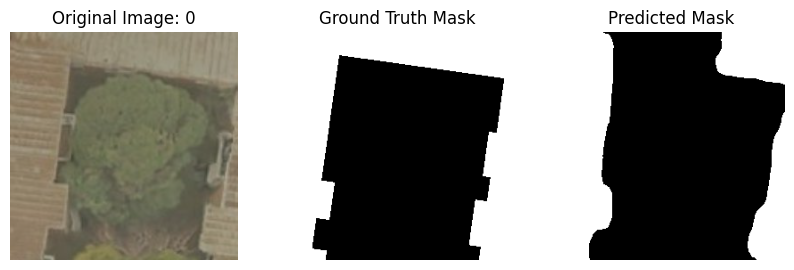

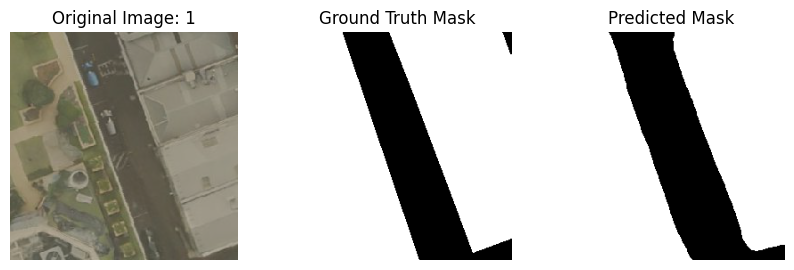

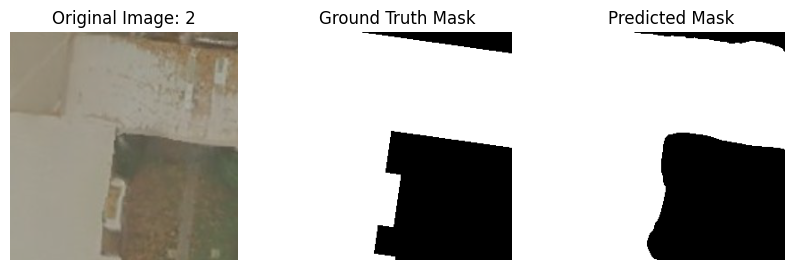

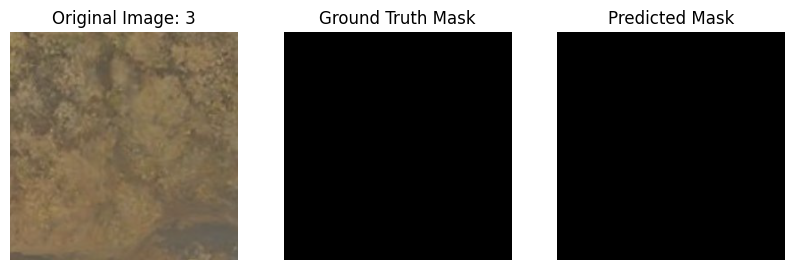

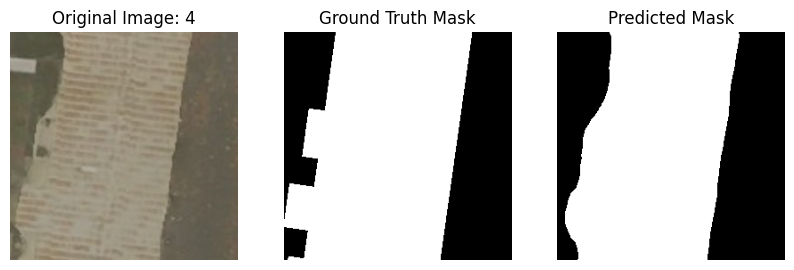

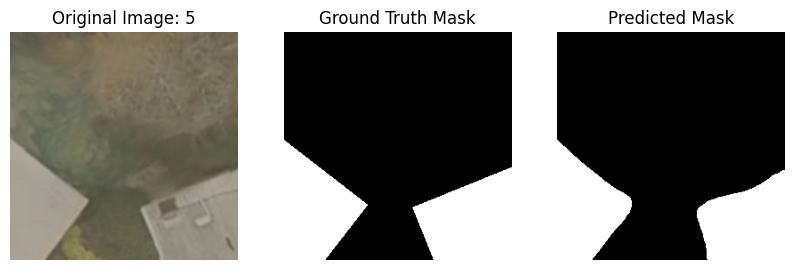

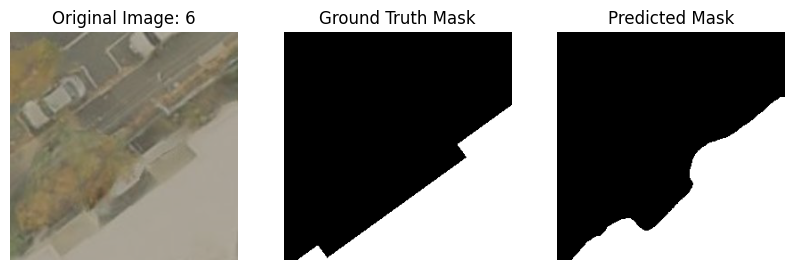

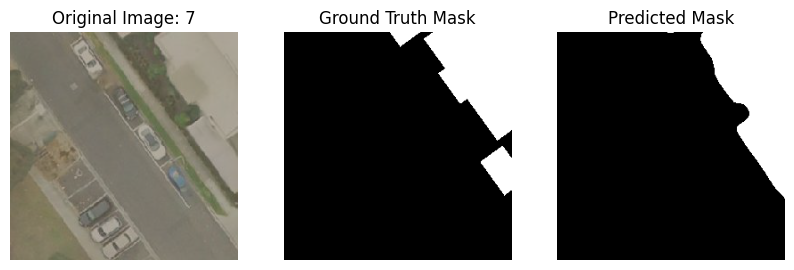

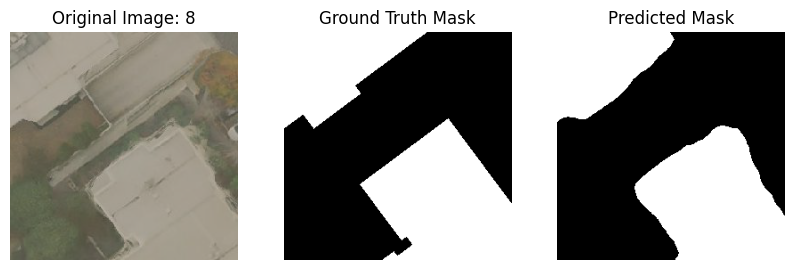

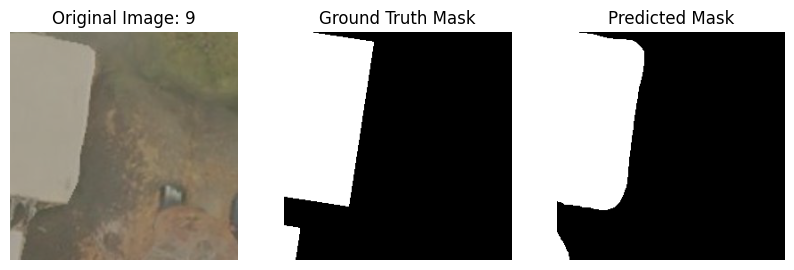

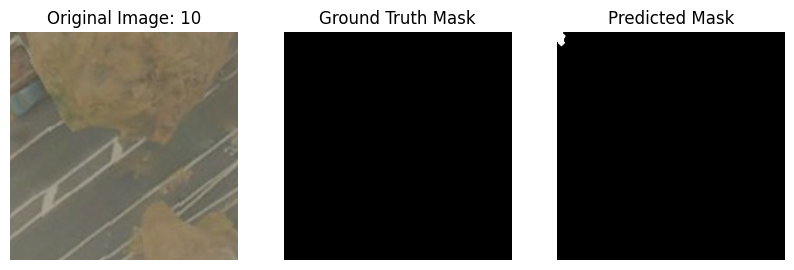

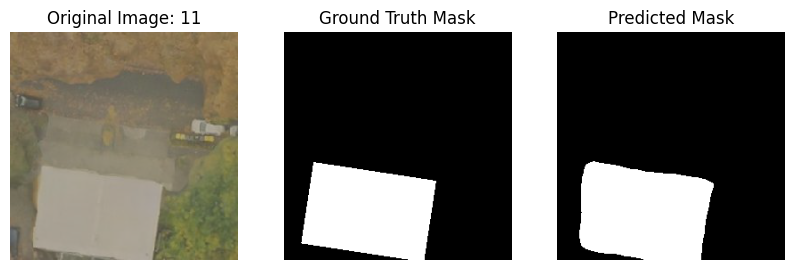

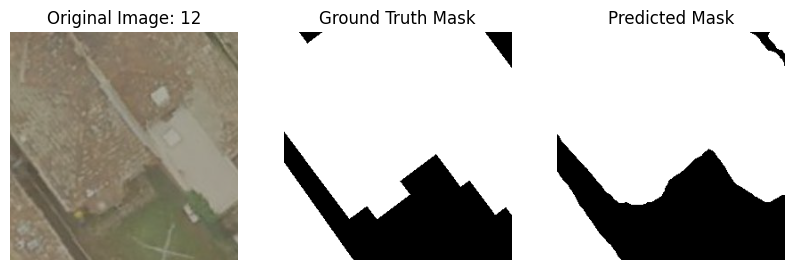

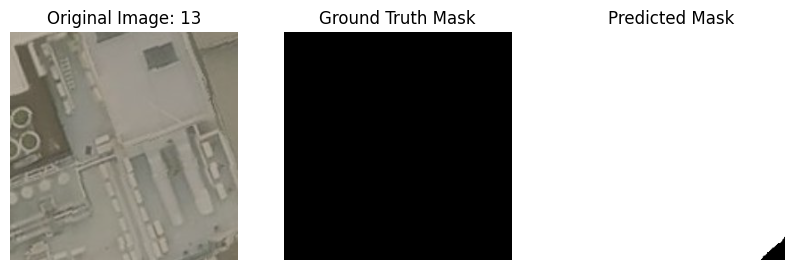

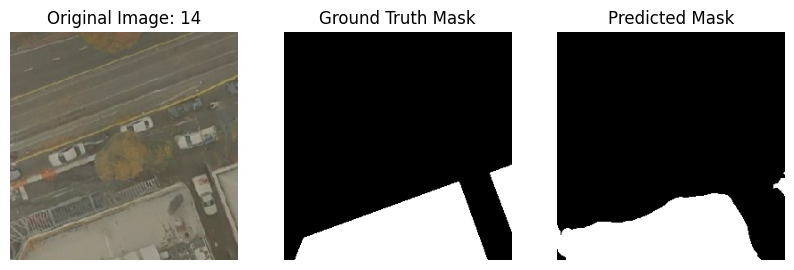

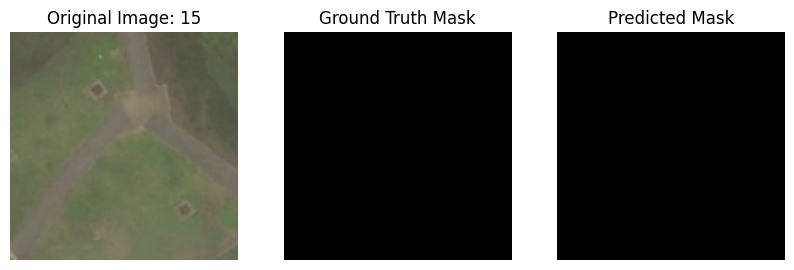

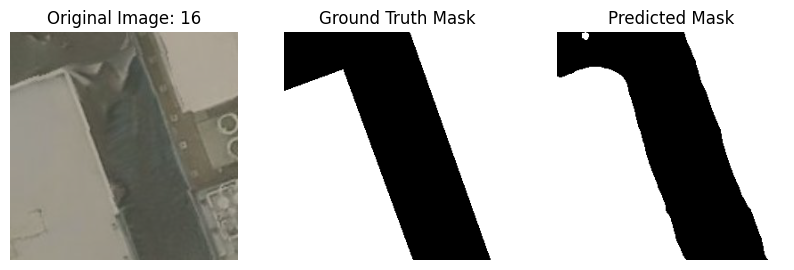

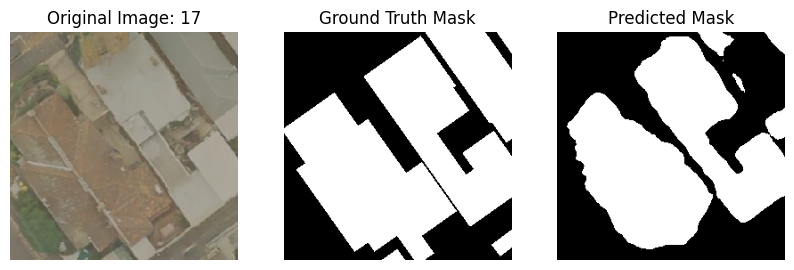

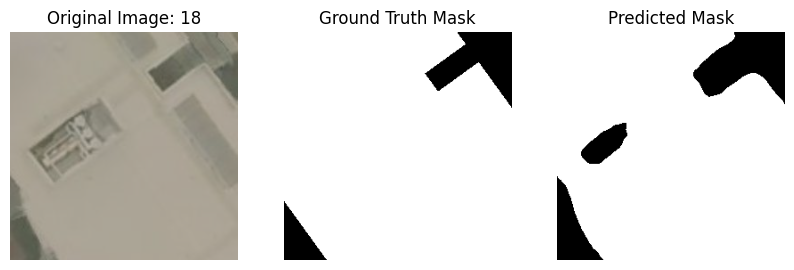

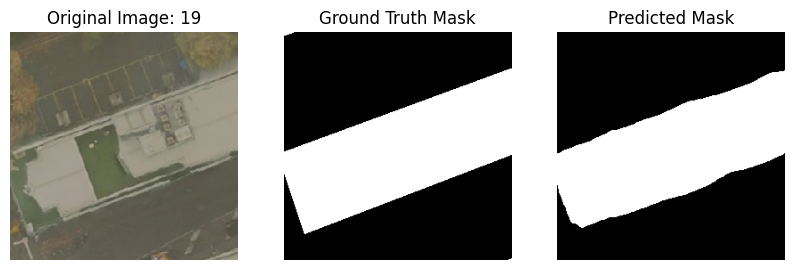

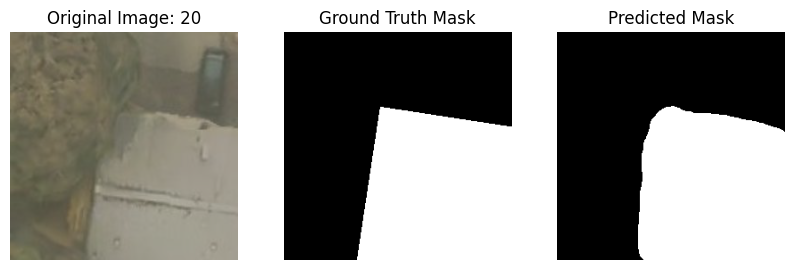

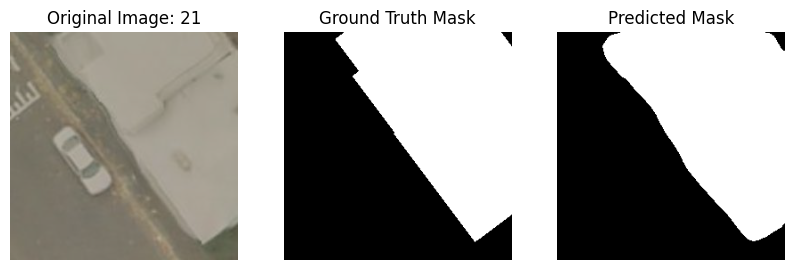

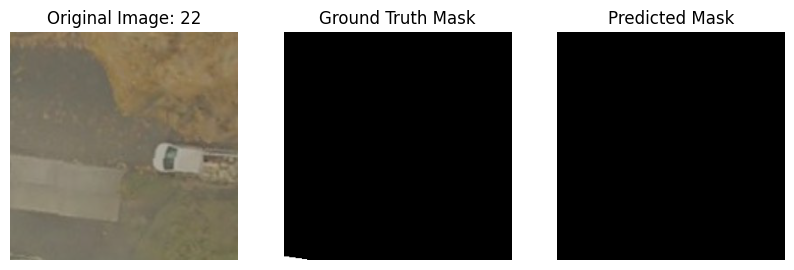

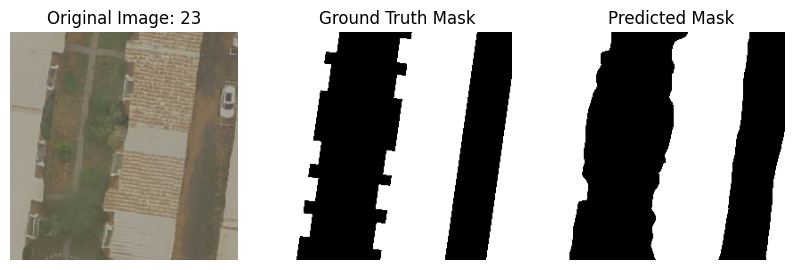

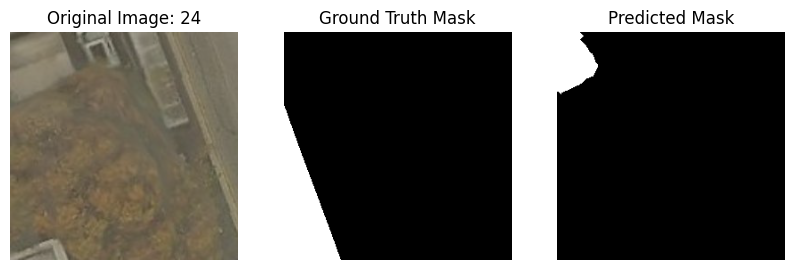

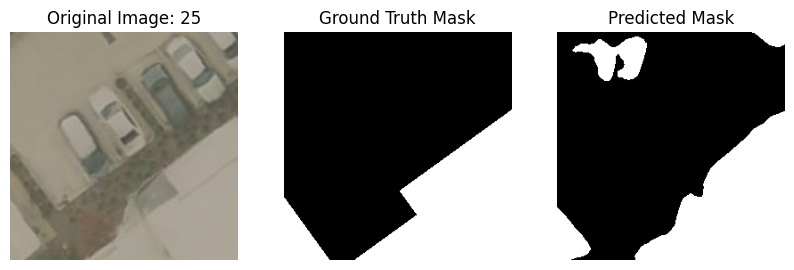

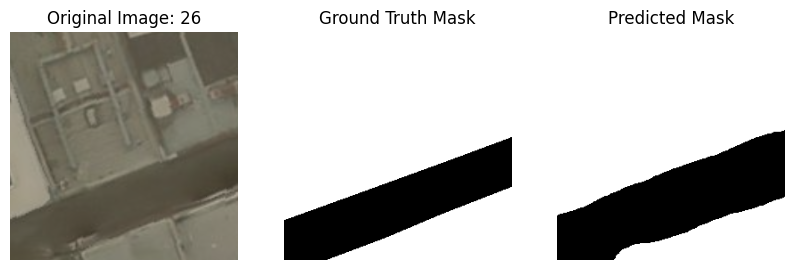

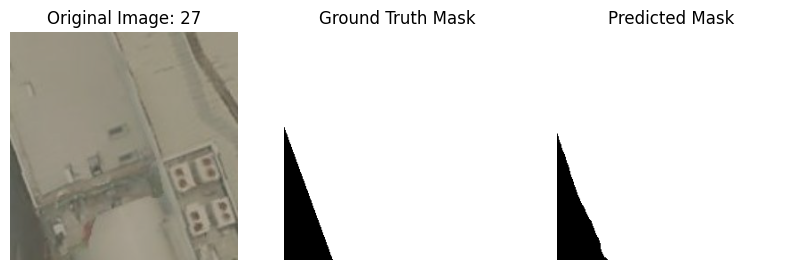

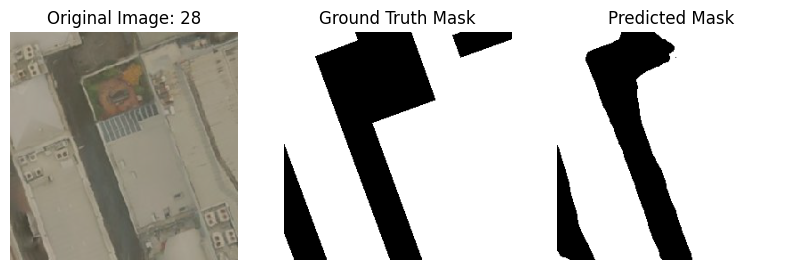

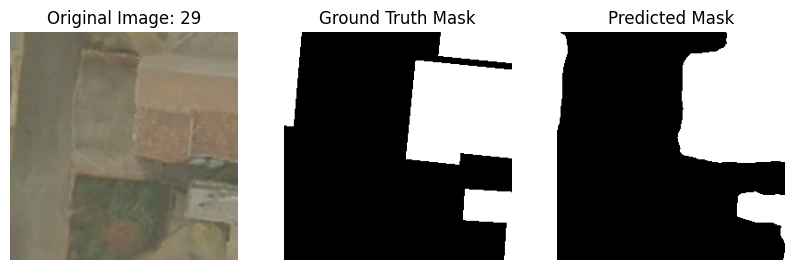

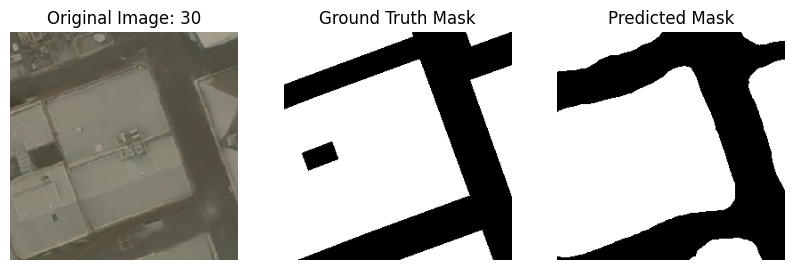

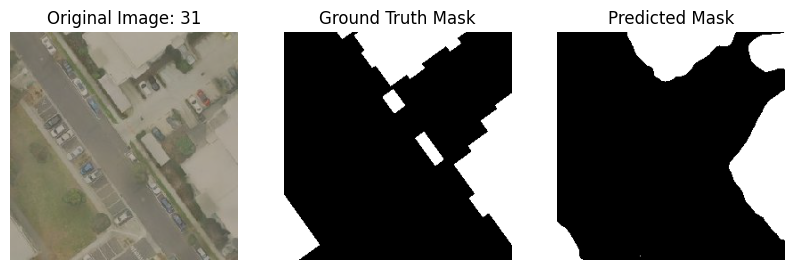

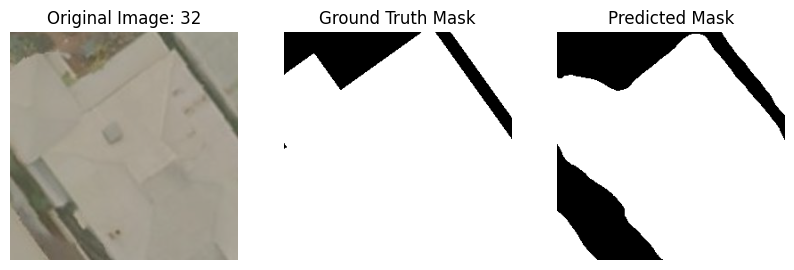

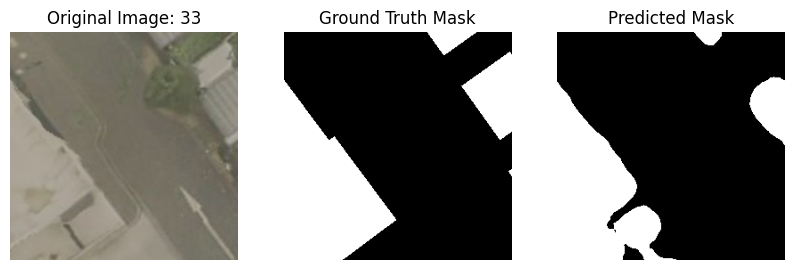

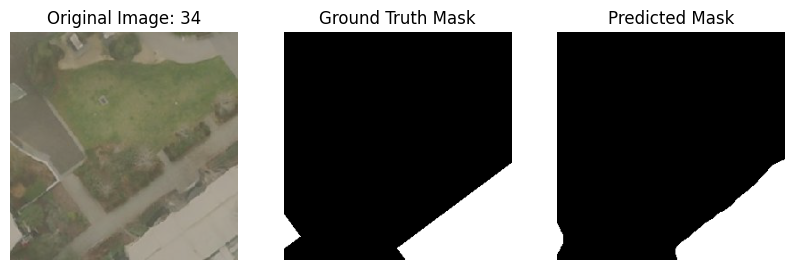

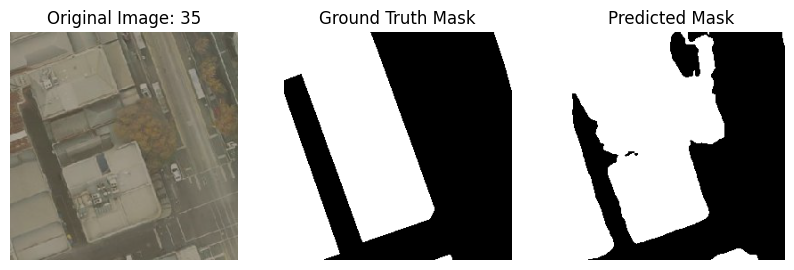

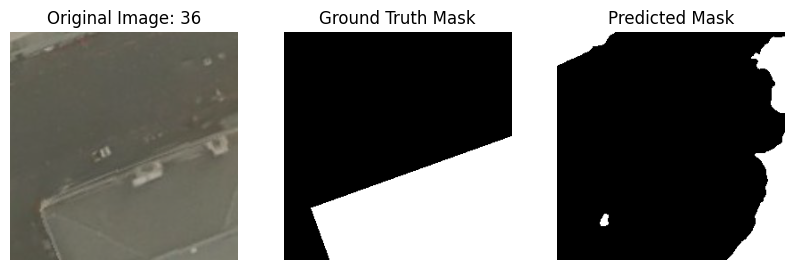

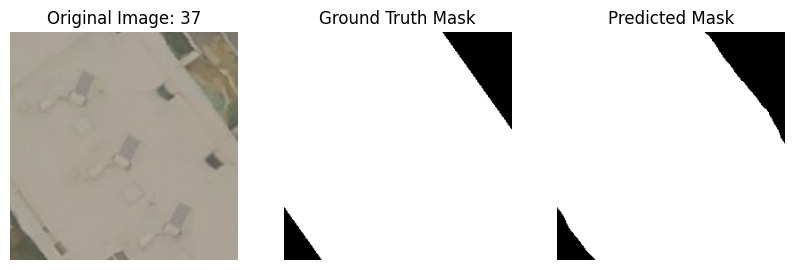

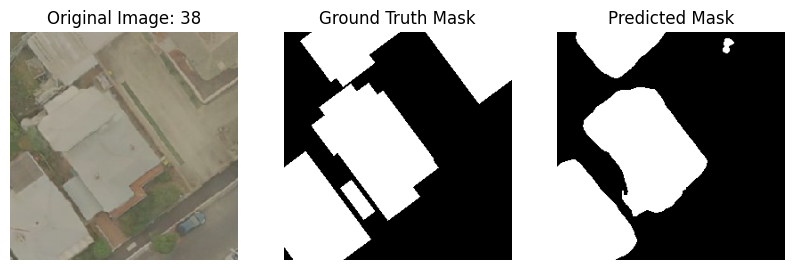

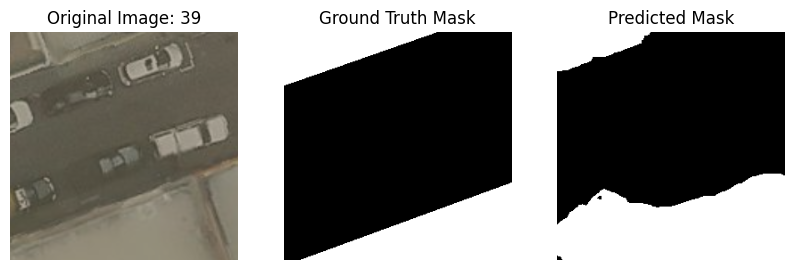

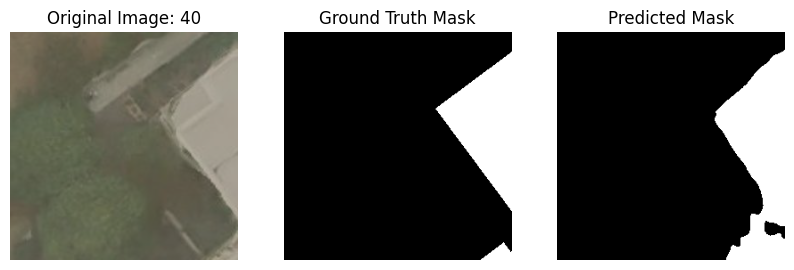

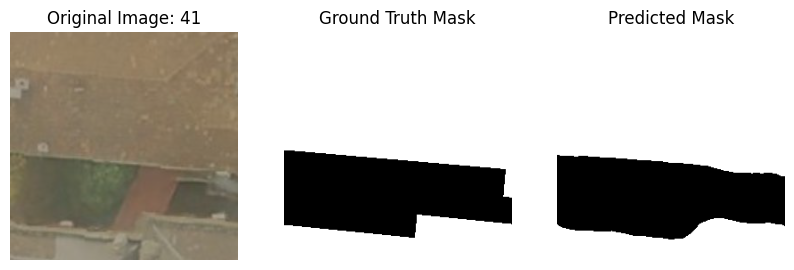

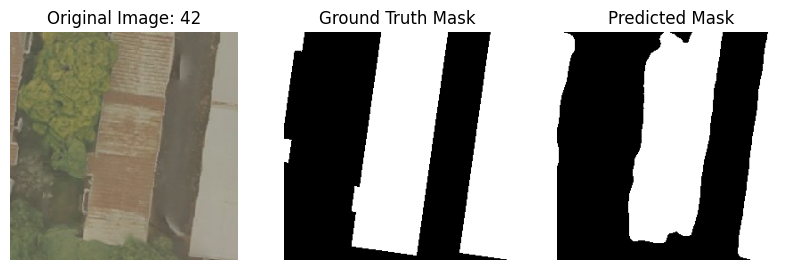

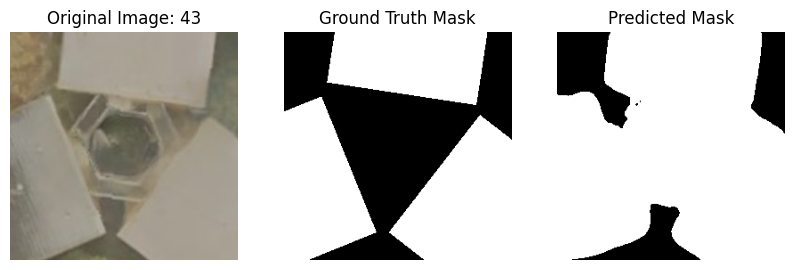

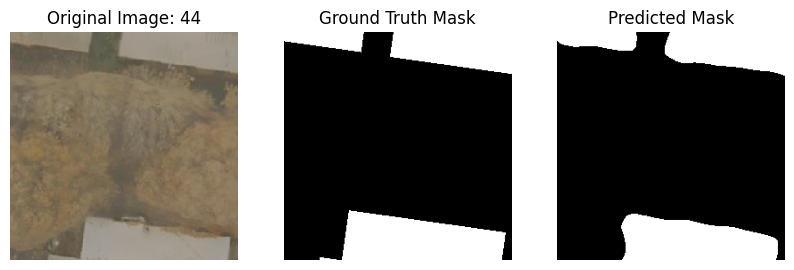

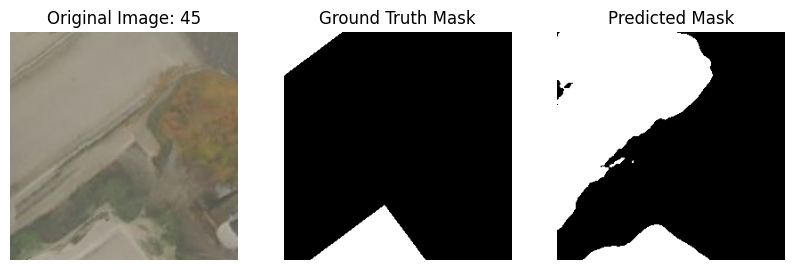

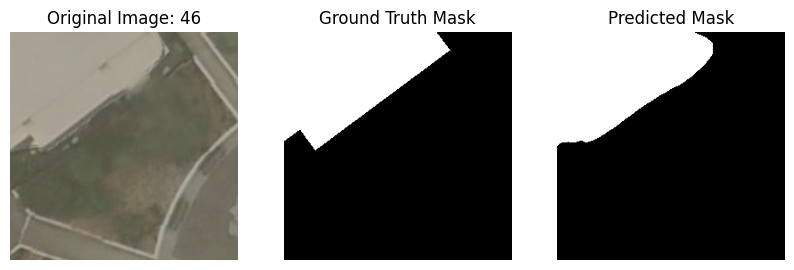

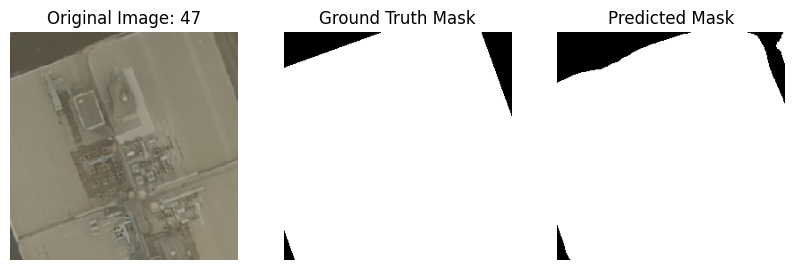

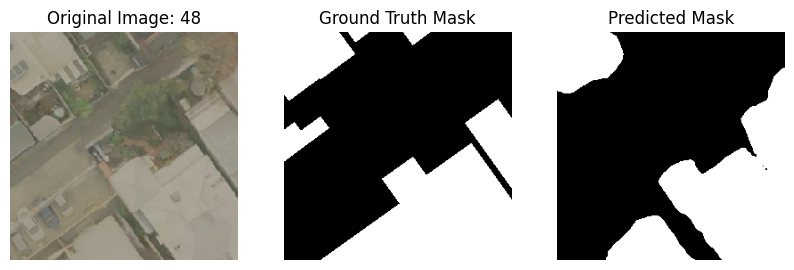

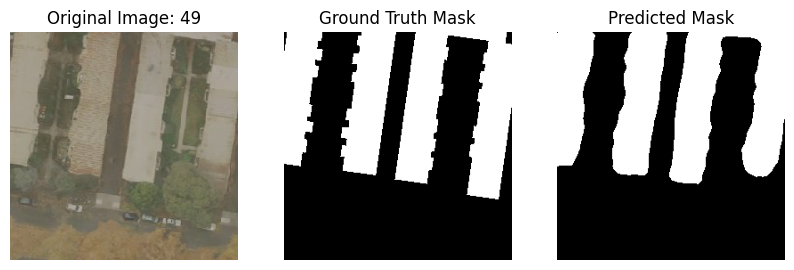

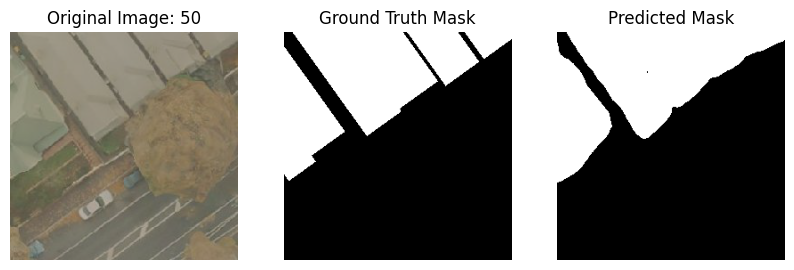

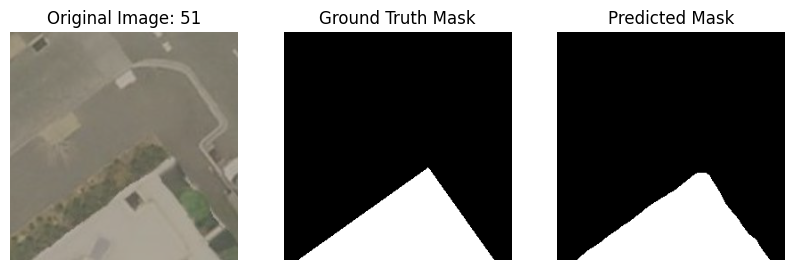

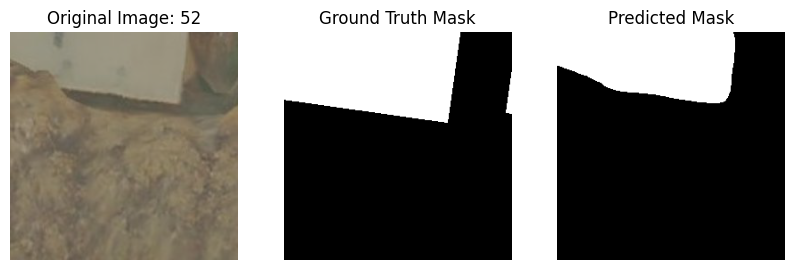

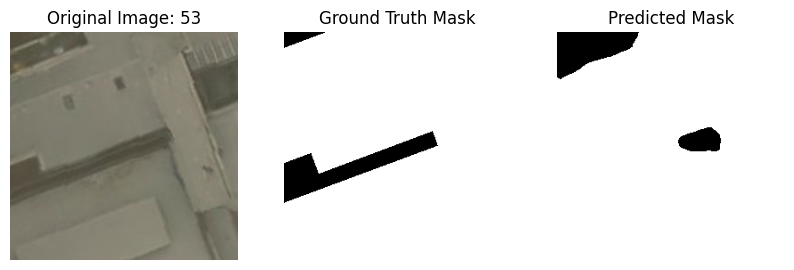

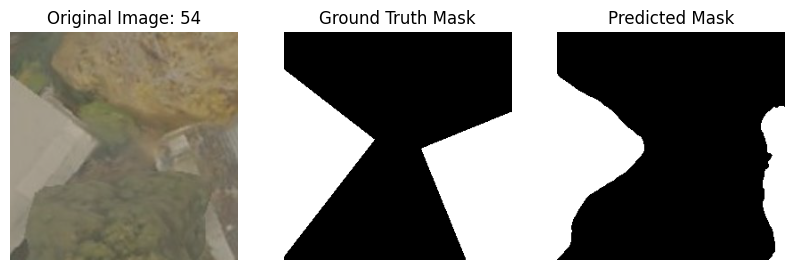

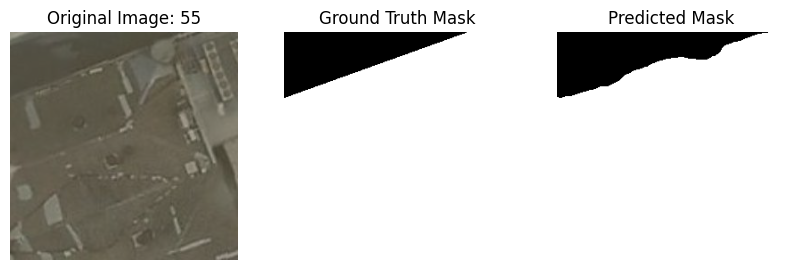

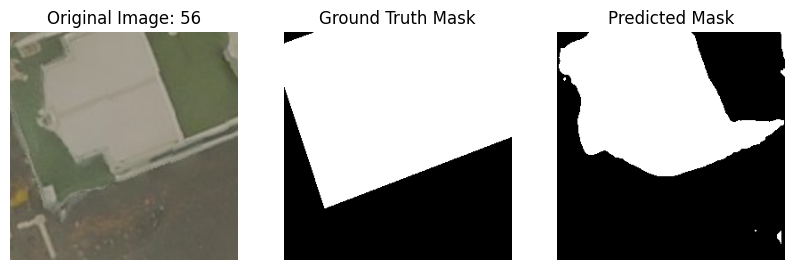

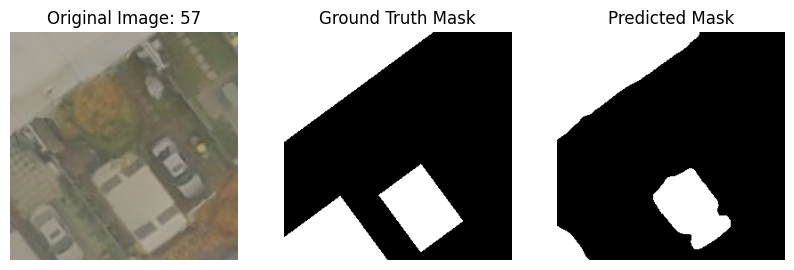

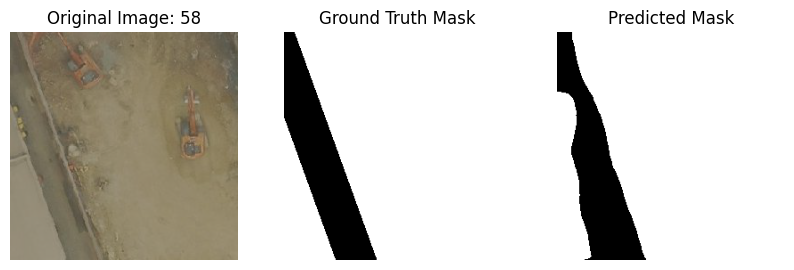

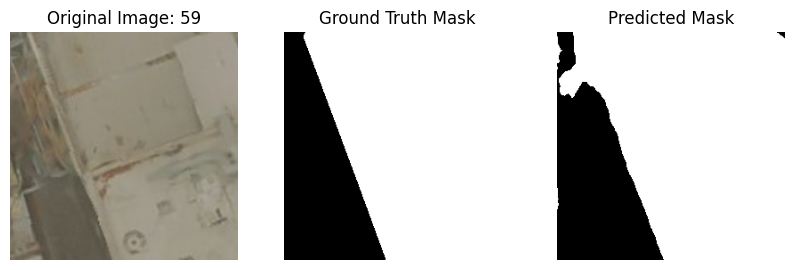

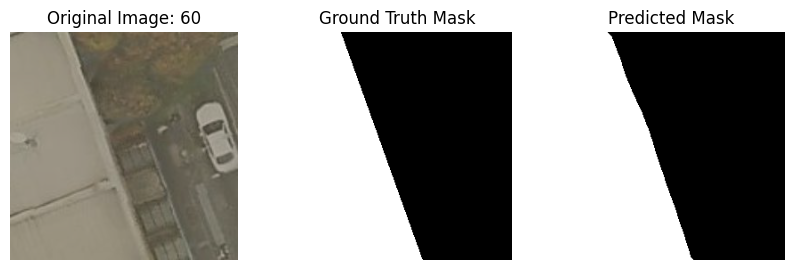

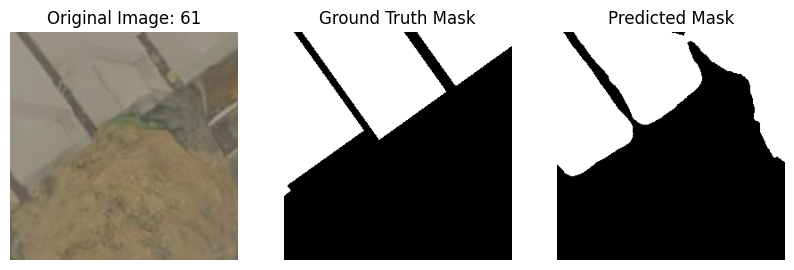

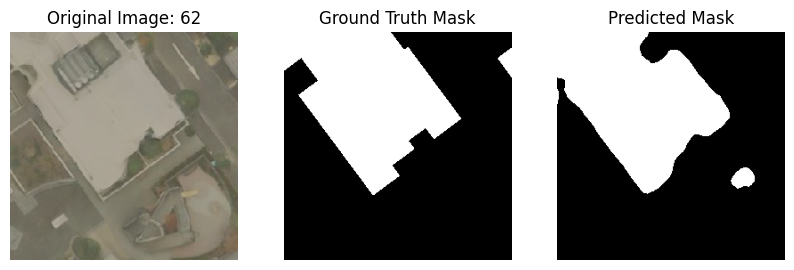

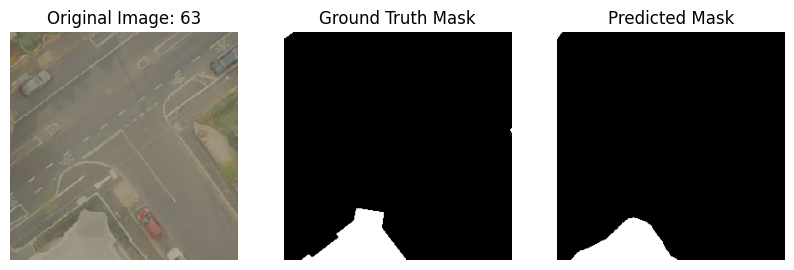

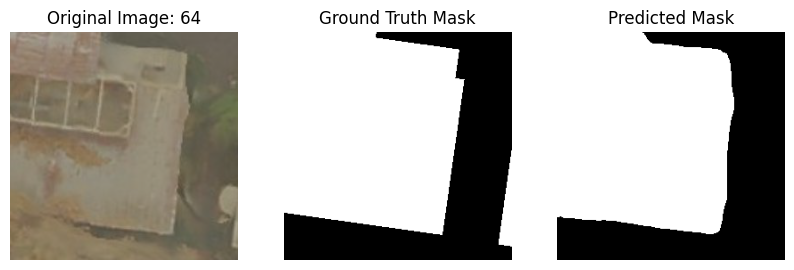

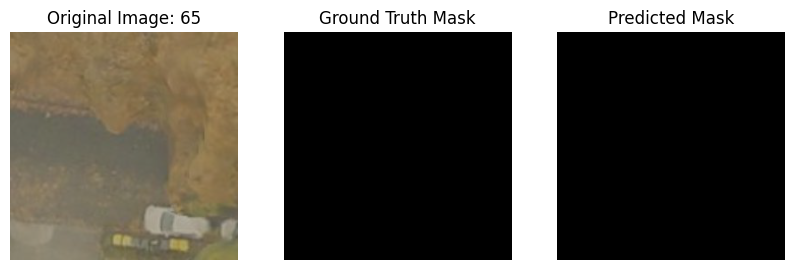

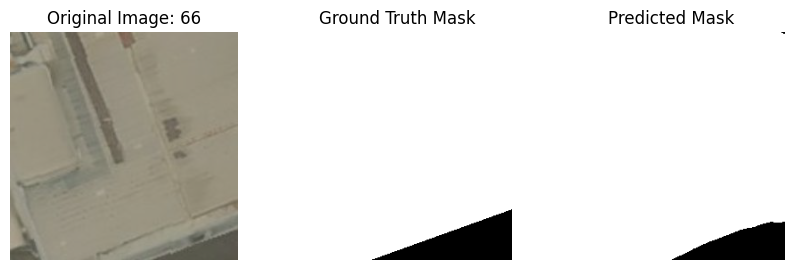

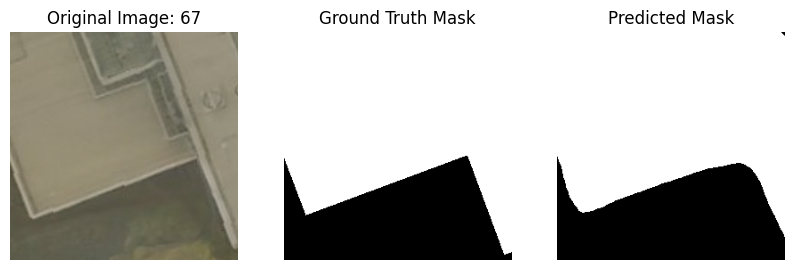

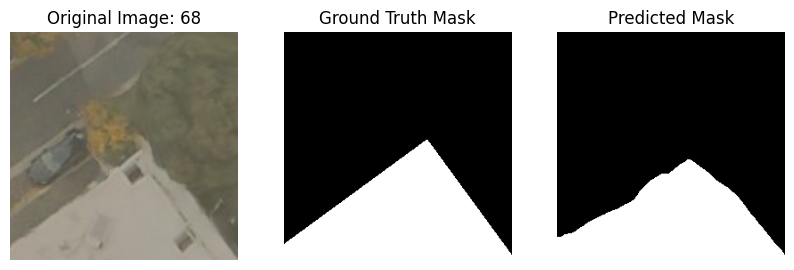

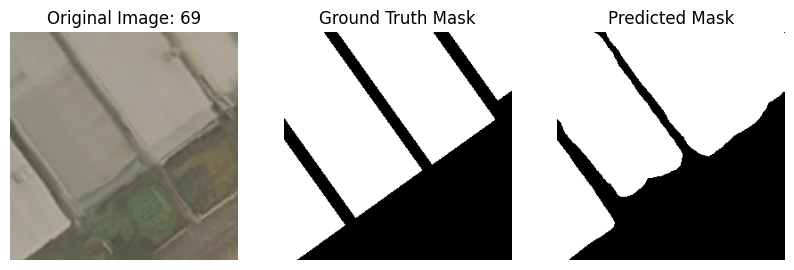

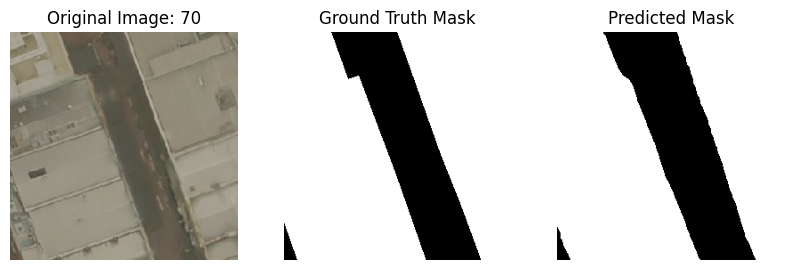

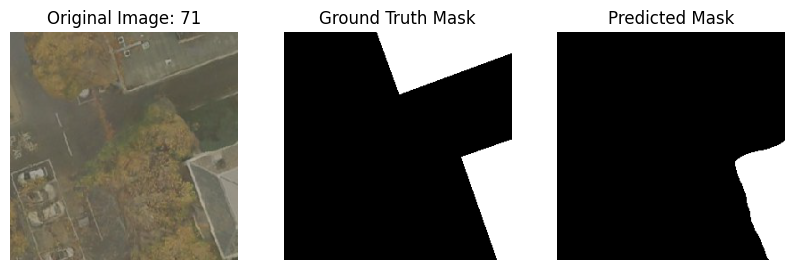

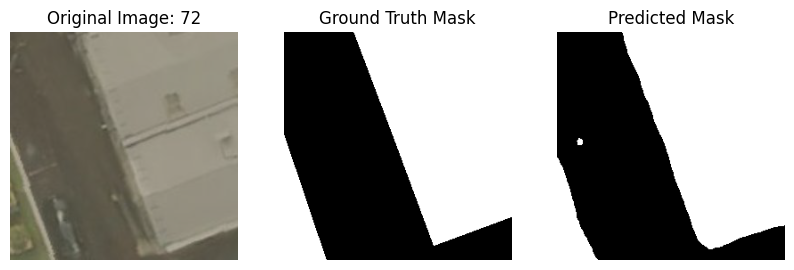

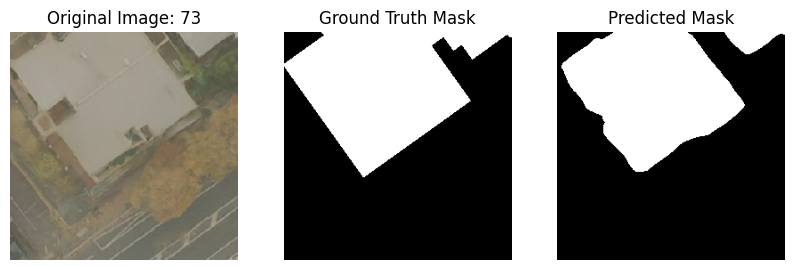

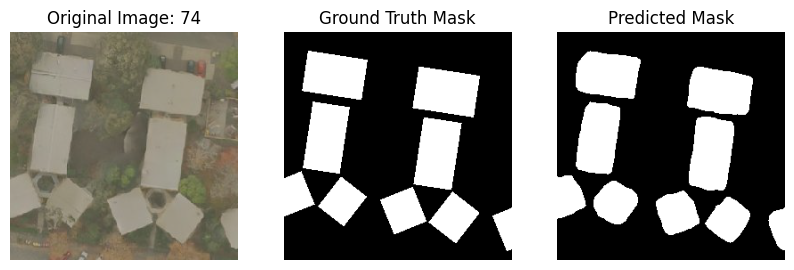

In [ ]:
# prompt: get predictions against the val dataset from val_loader and visualise the predictions

import matplotlib.pyplot as plt

# Assuming 'model' and 'val_loader' are defined as in your provided code

# Load the best model weights
# model.load_state_dict(torch.load('checkpoint.pt'))

# Set the model to evaluation mode
model.eval()
num_images_to_show = 10
rand_ix = np.random.choice(len(all_images_array),num_images_to_show,replace=False)
print(rand_ix)

def show_preds(idx_to_show):
# Visualize the results
  for i in idx_to_show:
      fig, axes = plt.subplots(1, 3, figsize=(10, 3))

      # Original Image
      axes[0].imshow(all_images_array[i].transpose(1, 2, 0))
      axes[0].set_title(f'Original Image: {i}')
      axes[0].axis('off')

      # Ground Truth Mask
      axes[1].imshow(all_masks_array[i], cmap='gray')
      axes[1].set_title('Ground Truth Mask')
      axes[1].axis('off')

      # Predicted Mask
      axes[2].imshow(all_preds_array[i], cmap='gray')
      axes[2].set_title('Predicted Mask')
      axes[2].axis('off')

    # plt.savefig('/content/drive/MyDrive/HOTOSM_leon_drive/semisupervised_examples/examples.png')

      plt.show()

show_preds(range(len(all_images_array)))


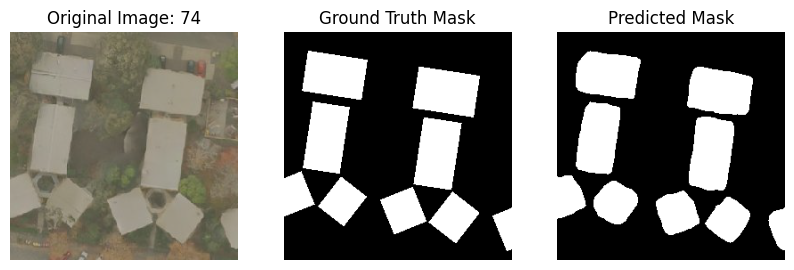

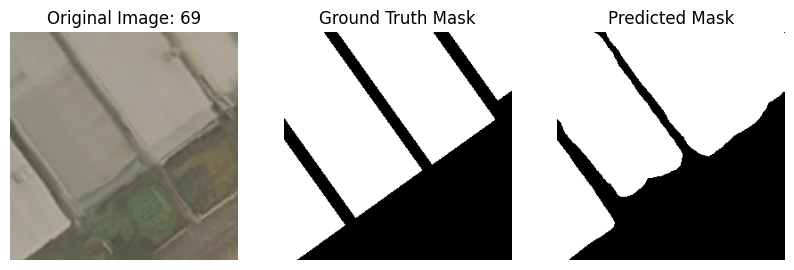

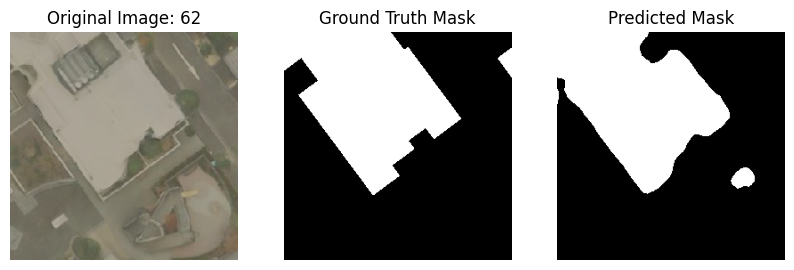

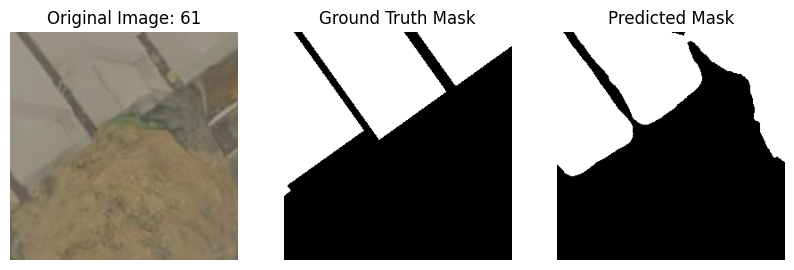

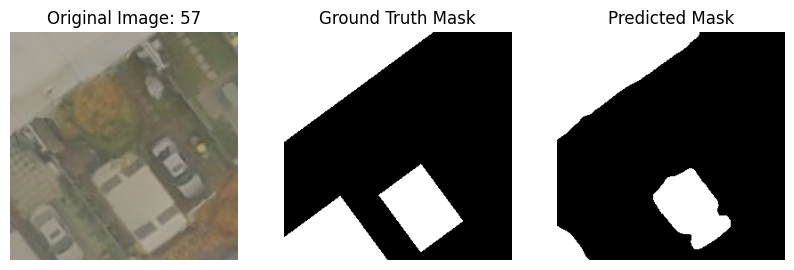

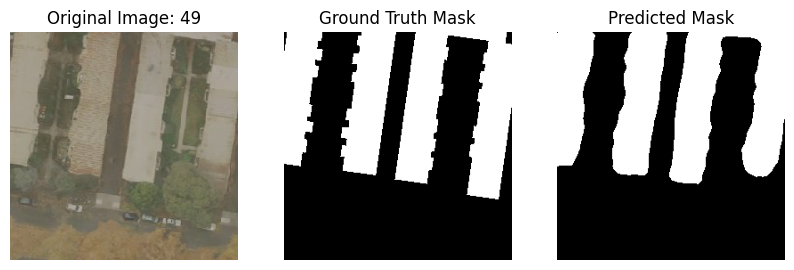

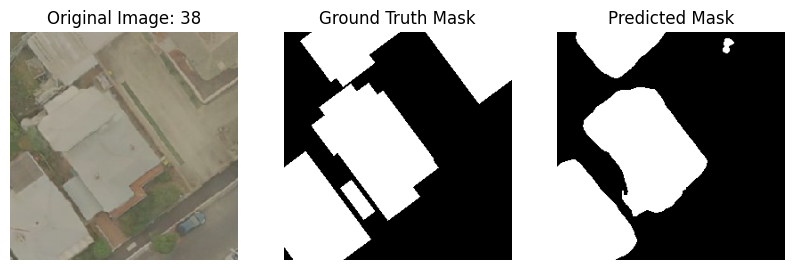

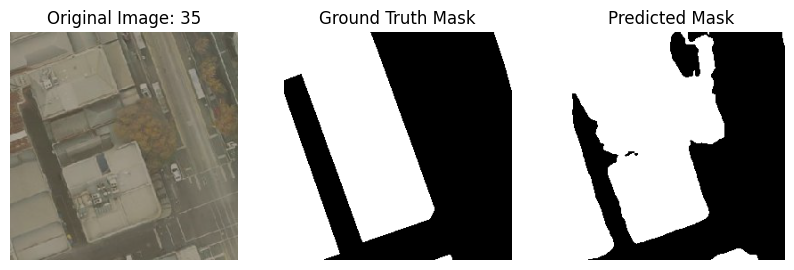

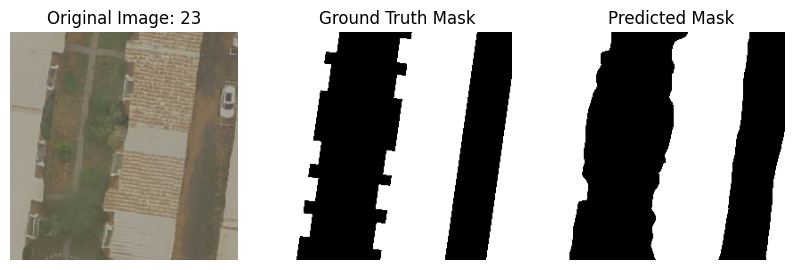

In [ ]:
good_examples = [74,69,62,61,57,49,38,35,23]
# bad_examples =
show_preds(good_examples)

In [ ]:
#make predictions:
breaker